In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.set_palette('Set2', n_colors=10)
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

import streamlit as st
from datetime import date

### 병원데이터

In [2]:
df1 = pd.read_csv('data/1. 병원정보서비스 2022.3.csv', encoding='cp949')

In [3]:
df1 = df1.drop_duplicates()

In [4]:
df1 = df1.drop(['종별코드'], axis=1)
df1 = df1.drop(['시도코드'], axis=1)
df1 = df1.drop(['시군구코드'], axis=1)
df1 = df1.drop(['읍면동'], axis=1)
df1 = df1.drop(['우편번호'], axis=1)
df1 = df1.drop(['주소'], axis=1)
df1 = df1.drop(['전화번호'], axis=1)
df1 = df1.drop(['병원URL'], axis=1)
df1 = df1.drop(['개설일자'], axis=1)

In [5]:
c = df1['시도코드명'] == '부산'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('부산', '')

c = df1['시도코드명'] == '대구'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('대구', '')

c = df1['시도코드명'] == '인천'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('인천', '')

c = df1['시도코드명'] == '대전'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('대전', '')

c = df1['시도코드명'] == '광주'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('광주', '')

c = df1['시도코드명'] == '울산'
df1.loc[c, '시군구코드명'] = df1.loc[c, '시군구코드명'].str.replace('울산', '')

df1.insert(5, '시도_군구', (df1['시도코드명'] + ' ' + df1['시군구코드명']))

2022-06-12 16:45:34.135 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


### 인구데이터

In [6]:
pop = pd.read_csv('data/202203_202203_연령별인구현황_월간.csv', encoding='cp949')

In [7]:
pop = pop.drop(['2022년03월_계_연령구간인구수'], axis=1)

col = ['행정구역', '총 인구수', '10세 미만', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100세 이상']
pop.columns = col

regions = ['전국', '서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종시', '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주']
pop['행정구역'] = regions

In [8]:
for i in pop.columns:
    if i == '행정구역':
        continue
    else:
        pop[i] = pop[i].str.replace(',','')
        pop[i] = pop[i].astype('int')

In [9]:
pop_total = pop[['행정구역', '총 인구수']]
pop_total = pop_total.drop(0)
pop_total = pop_total.set_index('행정구역')

### 응급실데이터

In [10]:
df4 = pd.read_csv('data/4. 의료기관별상세정보서비스 02세부정보 2022.3.csv', encoding='cp949')

In [11]:
df4 = df4.drop_duplicates()

In [12]:
col_4 = ['암호화요양기호', '요양기관명', '응급실 주간운영여부', '응급실 야간운영여부']
df4 = df4[col_4]

In [13]:
emer = ['Y', '당직의사만 근무합니다. 일반상담 가능합니다.', '정상 진료 (10:00~14:00)']
c1 = df4['응급실 주간운영여부'].isin(emer)
df4.loc[c1, '응급실 주간운영여부'] = 'Y'

In [14]:
c2 = (~df4['응급실 주간운영여부'].isin(emer))
df4.loc[c2, '응급실 주간운영여부'] = 'N'

In [15]:
df4['응급실 야간운영여부'] = df4['응급실 야간운영여부'].fillna('N')

In [16]:
emer = df1[['암호화요양기호', '요양기관명', '종별코드명', '시도코드명', '시도_군구', 'x좌표', 'y좌표']]

In [17]:
emer = pd.merge(emer, df4, on='암호화요양기호', how='inner')

In [18]:
emer = emer.drop('요양기관명_y', axis=1)

In [19]:
my_col = ['요양기호', '요양기관명', '종별코드명', '시도','시도_군구', 'x좌표', 'y좌표', '응급실 주간운영여부', '응급실 야간운영여부']
emer.columns = my_col

In [20]:
# 응급실 운영여부 column 생성

c1 = (emer['응급실 주간운영여부'] == 'Y')
c2 = (emer['응급실 야간운영여부'] == 'Y')

emer.loc[c1|c2, '응급실 운영여부'] = 'Y'
emer['응급실 운영여부'] = emer['응급실 운영여부'].fillna('N')

In [21]:
# 응급실 운영하는 병원만 추출

emer_y = emer[emer['응급실 운영여부'] == 'Y']

In [22]:
# 지역별 응급실 수

region_emer_y = emer_y.groupby('시도')[['요양기호']].count().reset_index()
region_emer_y = region_emer_y.rename({'요양기호':'응급실 수'}, axis=1)

In [23]:
region_hos = emer.groupby('시도')[['요양기호']].count().reset_index()
region_hos = region_hos.rename({'요양기호':'병원수'}, axis=1)

In [24]:
region_emer = pd.merge(region_emer_y,region_hos)
region_emer['병원 대비 응급실 비율'] = (region_emer['응급실 수'] / region_emer['병원수'])
region_emer = region_emer.sort_values('병원 대비 응급실 비율', ascending=False).reset_index(drop=True)

In [25]:
eme = pd.merge(region_emer, pop_total, left_on='시도', right_on='행정구역')
eme['인구 대비 응급실 비율'] = (eme['응급실 수'] / eme['총 인구수'])
eme = eme.sort_values(by='인구 대비 응급실 비율', ascending=False).reset_index(drop=True)

In [26]:
em = emer[['요양기관명', '종별코드명', '시도', '시도_군구', '응급실 주간운영여부', '응급실 야간운영여부', '응급실 운영여부']]

### 진료과목데이터

In [27]:
df5 = pd.read_csv('data/5. 의료기관별상세정보서비스 03진료과목정보 2022.3.csv', encoding='cp949')

In [28]:
df5 = df5.drop_duplicates()

In [29]:
col_5 = ['암호화요양기호', '요양기관명', '진료과목코드명']
df5 = df5[col_5]

In [30]:
sub = df1[['암호화요양기호', '요양기관명', '종별코드명', '시도코드명', '시도_군구', 'x좌표', 'y좌표']]

In [31]:
sub = pd.merge(sub, df5, on='암호화요양기호', how='inner')

In [32]:
sub = sub.drop('요양기관명_y', axis=1)

In [33]:
my_col = ['요양기호', '요양기관명', '종별코드명', '시도', '시도_군구', 'x좌표', 'y좌표', '진료과목']
sub.columns = my_col

In [34]:
sub = sub.drop('요양기호', axis=1)

### 의사수

In [35]:
인천 = df1[df1['시도코드명']=='인천']
강원 = df1[df1['시도코드명']=='강원']
서울 = df1[df1['시도코드명']=='서울']
대구 = df1[df1['시도코드명']=='대구']
경남 = df1[df1['시도코드명']=='경남']
경기 = df1[df1['시도코드명']=='경기']
충남 = df1[df1['시도코드명']=='충남']
부산 = df1[df1['시도코드명']=='부산']
전북 = df1[df1['시도코드명']=='전북']
광주 = df1[df1['시도코드명']=='광주']
대전 = df1[df1['시도코드명']=='대전']
충북 = df1[df1['시도코드명']=='충북']
울산 = df1[df1['시도코드명']=='울산']
전남 = df1[df1['시도코드명']=='전남']
경북 = df1[df1['시도코드명']=='경북']
세종시 = df1[df1['시도코드명']=='세종시']
제주 = df1[df1['시도코드명']=='제주']

In [36]:
# 외과

col3=['의과일반의 의원수', '의과인턴 의사수', '의과레지던트 의사수', '의과전문의 의사수']

incheon_doc = 인천.iloc[:,[7,8,9,10]].sum().sum()
gangwon_doc = 강원.iloc[:,[7,8,9,10]].sum().sum()
seoul_doc = 서울.iloc[:,[7,8,9,10]].sum().sum()
daegu_doc = 대구.iloc[:,[7,8,9,10]].sum().sum()
gyeongnam_doc = 경남.iloc[:,[7,8,9,10]].sum().sum()
kyeonggi_doc = 경기.iloc[:,[7,8,9,10]].sum().sum()
chungnam_doc = 충남.iloc[:,[7,8,9,10]].sum().sum()
busan_doc = 부산.iloc[:,[7,8,9,10]].sum().sum()
jeonbuk_doc = 전북.iloc[:,[7,8,9,10]].sum().sum()
gwangju_doc = 광주.iloc[:,[7,8,9,10]].sum().sum()
daejeon_doc = 대전.iloc[:,[7,8,9,10]].sum().sum()
chungbuk_doc = 충북.iloc[:,[7,8,9,10]].sum().sum()
ulsan_doc = 울산.iloc[:,[7,8,9,10]].sum().sum()
jeonnam_doc = 전남.iloc[:,[7,8,9,10]].sum().sum()
gyeongbuk_doc = 경북.iloc[:,[7,8,9,10]].sum().sum()
sejong_doc = 세종시.iloc[:,[7,8,9,10]].sum().sum()
jeju_doc = 제주.iloc[:,[7,8,9,10]].sum().sum()

raw_data = {'지역' : ['인천', '강원', '서울', '대구', '경남', '경기', '충남', '부산', '전북', 
                    '광주', '대전', '충북', '울산', '전남', '경북', '세종시','제주'],
           '외과 의사수' : [incheon_doc, gangwon_doc, seoul_doc, daegu_doc, gyeongnam_doc, kyeonggi_doc, chungnam_doc, busan_doc,
          jeonbuk_doc, gwangju_doc, daejeon_doc, chungbuk_doc, ulsan_doc, jeonnam_doc, gyeongbuk_doc, sejong_doc, jeju_doc]}

data_doc = pd.DataFrame(raw_data)
data_doc = data_doc.set_index("지역")

In [37]:
doctor = pd.concat([pop_total, data_doc], axis=1)

doctor['인구 당 외과의 비율'] = (doctor['외과 의사수'] / doctor['총 인구수']) *100

In [38]:
# 치과

incheon_den = 인천.iloc[:,[11,12,13,14]].sum().sum()
gangwon_den = 강원.iloc[:,[11,12,13,14]].sum().sum()
seoul_den = 서울.iloc[:,[11,12,13,14]].sum().sum()
daegu_den = 대구.iloc[:,[11,12,13,14]].sum().sum()
gyeongnam_den = 경남.iloc[:,[11,12,13,14]].sum().sum()
kyeonggi_den = 경기.iloc[:,[11,12,13,14]].sum().sum()
chungnam_den = 충남.iloc[:,[11,12,13,14]].sum().sum()
busan_den = 부산.iloc[:,[11,12,13,14]].sum().sum()
jeonbuk_den = 전북.iloc[:,[11,12,13,14]].sum().sum()
gwangju_den = 광주.iloc[:,[11,12,13,14]].sum().sum()
daejeon_den = 대전.iloc[:,[11,12,13,14]].sum().sum()
chungbuk_den = 충북.iloc[:,[11,12,13,14]].sum().sum()
ulsan_den = 울산.iloc[:,[11,12,13,14]].sum().sum()
jeonnam_den = 전남.iloc[:,[11,12,13,14]].sum().sum()
gyeongbuk_den = 경북.iloc[:,[11,12,13,14]].sum().sum()
sejong_den = 세종시.iloc[:,[11,12,13,14]].sum().sum()
jeju_den = 제주.iloc[:,[11,12,13,14]].sum().sum()

raw_data = {'지역' : ['인천', '강원', '서울', '대구', '경남', '경기', '충남', '부산', '전북', 
                    '광주', '대전', '충북', '울산', '전남', '경북', '세종시','제주'],
           '치과 의사수' : [incheon_den, gangwon_den, seoul_den, daegu_den, gyeongnam_den, kyeonggi_den, chungnam_den, busan_den,
          jeonbuk_den, gwangju_den, daejeon_den, chungbuk_den, ulsan_den, jeonnam_den, gyeongbuk_den, sejong_den, jeju_den]}
data_den = pd.DataFrame(raw_data)
data_den = data_den.set_index("지역")

In [39]:
doctor = pd.concat([doctor, data_den], axis=1)
doctor['인구 당 치과의 비율'] = (doctor['치과 의사수'] / doctor['총 인구수']) *100

In [40]:
# 한의과

incheon_han = 인천.iloc[:,[15,16,17,18]].sum().sum()
gangwon_han = 강원.iloc[:,[15,16,17,18]].sum().sum()
seoul_han = 서울.iloc[:,[15,16,17,18]].sum().sum()
daegu_han = 대구.iloc[:,[15,16,17,18]].sum().sum()
gyeongnam_han = 경남.iloc[:,[15,16,17,18]].sum().sum()
kyeonggi_han = 경기.iloc[:,[15,16,17,18]].sum().sum()
chungnam_han = 충남.iloc[:,[15,16,17,18]].sum().sum()
busan_han = 부산.iloc[:,[15,16,17,18]].sum().sum()
jeonbuk_han = 전북.iloc[:,[15,16,17,18]].sum().sum()
gwangju_han = 광주.iloc[:,[15,16,17,18]].sum().sum()
daejeon_han = 대전.iloc[:,[15,16,17,18]].sum().sum()
chungbuk_han = 충북.iloc[:,[15,16,17,18]].sum().sum()
ulsan_han = 울산.iloc[:,[15,16,17,18]].sum().sum()
jeonnam_han = 전남.iloc[:,[15,16,17,18]].sum().sum()
gyeongbuk_han = 경북.iloc[:,[15,16,17,18]].sum().sum()
sejong_han = 세종시.iloc[:,[15,16,17,18]].sum().sum()
jeju_han = 제주.iloc[:,[15,16,17,18]].sum().sum()

raw_data = {'지역' : ['인천', '강원', '서울', '대구', '경남', '경기', '충남', '부산', '전북', 
                    '광주', '대전', '충북', '울산', '전남', '경북', '세종시','제주'],
           '한의과 의사수' : [incheon_han, gangwon_han, seoul_han, daegu_han, gyeongnam_han, kyeonggi_han, chungnam_han, busan_han,
          jeonbuk_han, gwangju_han, daejeon_han, chungbuk_han, ulsan_han, jeonnam_han, gyeongbuk_han, sejong_han, jeju_han]}
data_han = pd.DataFrame(raw_data)
data_han = data_han.set_index("지역")

In [41]:
doctor = pd.concat([doctor,data_han], axis =1)
doctor['인구 당 한의과의 비율'] = (doctor['한의과 의사수'] / doctor['총 인구수']) *100

In [42]:
doctor = doctor.reset_index()
doctor = doctor.rename(columns = {'index' : '지역'})

### 영유아, 노인

In [43]:
df3 = pd.read_csv('data/3. 의료기관별상세정보서비스 01시설정보 2022.3.csv', encoding='cp949')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
con = df3[df3['종별코드명'] == '요양병원']

In [45]:
old1 = con.groupby(['시도코드명'])[['종별코드명']].count().reset_index()
old1 = old1.rename(columns={'종별코드명':'요양병원개수'})

In [46]:
young1=df3.groupby(['시도코드명'])[['소아중환자병상수','신생아중환자병상수','분만실병상수']].sum().reset_index()

In [47]:
age_hos = pd.merge(young1, old1, on='시도코드명')

In [48]:
old_age = pd.read_csv('data/연장자.csv' , encoding='cp949')

In [49]:
old_age['행정구역'][0]='전국'
old_age['행정구역'][1]='서울'
old_age['행정구역'][2]='부산'
old_age['행정구역'][3]='대구'
old_age['행정구역'][4]='인천'
old_age['행정구역'][5]='광주'
old_age['행정구역'][6]='대전'
old_age['행정구역'][7]='울산'
old_age['행정구역'][8]='세종시'
old_age['행정구역'][9]='경기'
old_age['행정구역'][10]='강원'
old_age['행정구역'][11]='충북'
old_age['행정구역'][12]='충남'
old_age['행정구역'][13]='전북'
old_age['행정구역'][14]='전남'
old_age['행정구역'][15]='경북'
old_age['행정구역'][16]='경남'
old_age['행정구역'][17]='제주'
old_age = old_age.set_index('행정구역')
old_age = old_age.drop('전국')
old_age = old_age.reset_index()
old_age.rename(columns = {'2022년03월_계_연령구간인구수': '총노인인구수'}, inplace = True)

In [50]:
old = old_age[['총노인인구수','행정구역']]

In [51]:
young_age = pd.read_csv('data/영유아.csv' , encoding='cp949')

In [52]:
young_age['행정구역'][0]='전국'
young_age['행정구역'][1]='서울'
young_age['행정구역'][2]='부산'
young_age['행정구역'][3]='대구'
young_age['행정구역'][4]='인천'
young_age['행정구역'][5]='광주'
young_age['행정구역'][6]='대전'
young_age['행정구역'][7]='울산'
young_age['행정구역'][8]='세종시'
young_age['행정구역'][9]='경기'
young_age['행정구역'][10]='강원'
young_age['행정구역'][11]='충북'
young_age['행정구역'][12]='충남'
young_age['행정구역'][13]='전북'
young_age['행정구역'][14]='전남'
young_age['행정구역'][15]='경북'
young_age['행정구역'][16]='경남'
young_age['행정구역'][17]='제주'
young_age=young_age.set_index('행정구역')
young_age=young_age.drop('전국')
young_age=young_age.reset_index()
young_age.rename(columns = {'2022년03월_계_0세': '영유아인구수'}, inplace = True)

In [53]:
baby = young_age[['영유아인구수','행정구역']]

In [54]:
age_pop = pop.set_index('행정구역')
age_pop = age_pop.drop('전국')
age_pop = age_pop.reset_index()
age_pop = age_pop.rename(columns={'10세 미만':'소아인구수'})
child = age_pop[['행정구역', '소아인구수', '총 인구수']]

In [55]:
child.rename(columns = {'행정구역': '시도코드명'}, inplace = True)
baby.rename(columns = {'행정구역': '시도코드명'}, inplace = True)
old.rename(columns = {'행정구역': '시도코드명'}, inplace = True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [56]:
age_total = pd.merge(age_hos, old, on='시도코드명')
age_total = pd.merge(age_total, baby, on='시도코드명')
age_total = pd.merge(age_total, child, on='시도코드명')

In [57]:
age_total.rename(columns = {'총노인인구수': '총노인인구수(65세이상)','영유아인구수':'영유아인구수(0세)','소아인구수':'소아인구수(0~9세)'}, inplace = True)

In [58]:
age_total['영유아인구수(0세)'] = age_total['영유아인구수(0세)'].str.replace(',', '')
age_total['총노인인구수(65세이상)'] = age_total['총노인인구수(65세이상)'].str.replace(',', '')

age_total['총노인인구수(65세이상)'] = age_total['총노인인구수(65세이상)'].astype('int')
age_total['영유아인구수(0세)'] = age_total['영유아인구수(0세)'].astype('int')

In [59]:
age_total['신생아중환자병상비율']=age_total['신생아중환자병상수']/age_total['영유아인구수(0세)']
age_total['노인요양병원비율']=age_total['요양병원개수']/age_total['총노인인구수(65세이상)']

### 전문병원데이터

In [60]:
df9 = pd.read_csv('data/11. 의료기관별상세정보서비스 09전문병원지정분야 2022.3.csv', encoding='euc-kr')
df9 = df9.drop_duplicates()

In [61]:
sp = df1[['암호화요양기호', '요양기관명', '종별코드명', '시도코드명', '시도_군구', 'x좌표', 'y좌표']]
sp = pd.merge(sp, df9, how='right', on='암호화요양기호')
sp = sp.drop('요양기관명_y', axis=1)
sp = sp.drop('암호화요양기호', axis=1)
sp = sp.rename(columns = {'요양기관명_x':'요양기관명'})

### 병원데이터 정리

In [62]:
df = df1[['종별코드명', '시도코드명', '총의사수', 'x좌표', 'y좌표']]
df = df.rename(columns = {'x좌표':'lon', 'y좌표':'lat'})
location = df.dropna()

# <span style="color:blue"> *****Data App*****

In [63]:
# 기본 설정

st.set_page_config(page_title='Hospital Dashboard',
                  page_icon = '🏥', layout='wide')

st.title('Hospital Dashboard')

if st.button('새로고침'):
    st.experimental_rerun()

2022-06-12 16:45:37.967 
  command:

    streamlit run C:\Anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [64]:
# 원본 데이터 살려놓기

my_df = df.copy()
my_doctor = doctor.copy()
my_sub = sub.copy()
my_em = em.copy()
my_sp = sp.copy()
my_location = location.copy()
my_age_total = age_total.copy()

In [65]:
# 사이드바 설정

st.sidebar.title('조건 필터')
st.sidebar.header('종별코드 선택')

DeltaGenerator(_root_container=1, _provided_cursor=None, _parent=DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None), _block_type=None, _form_data=None)

In [66]:
# 사이드바 선택으로 데이터 필터링

side_option = st.sidebar.multiselect('종별코드명', (df['종별코드명'].unique()),
                                    default=(df['종별코드명'].unique()))

my_df = my_df[my_df['종별코드명'].isin(side_option)]
my_sub = my_sub[my_sub['종별코드명'].isin(side_option)]
my_em = my_em[my_em['종별코드명'].isin(side_option)]
my_sp = my_sp[my_sp['종별코드명'].isin(side_option)]
my_location = my_location[my_location['종별코드명'].isin(side_option)]

In [67]:
st.header('0. Overview')

col = ['외과 의사수', '치과 의사수',' 한의과 의사수']
col1, col2 = st.columns(2)

col1.metric(label = "전국 의료시설 수", value = my_df['종별코드명'].count().sum())
col2.metric(label = "전국 의사 수", value = my_df['총의사수'].sum() )

'DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)'

In [68]:
st.write('지역별분포')
jit = np.random.randn(len(my_location), 2)
jit_ratio = 0.01
my_location[['lat','lon']] = my_location[['lat','lon']] + jit*jit_ratio
st.map(my_location)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [69]:
st.header('1. 진료과목')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

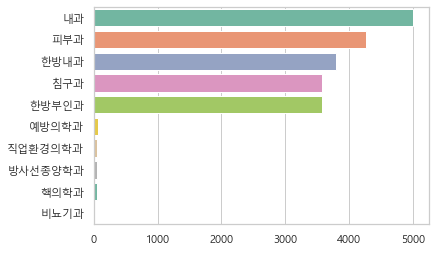

In [70]:
st.subheader('진료과목 비교')

city_range = st.selectbox(label="지역선택", options=('서울', '경기','부산','경남','인천','대구','경북','대전','전북','충남','전남','광주','충북','강원','울산','제주','세종시'), index=0)

my_sub_city = my_sub[my_sub['시도'] == city_range]
my_sub_city = my_sub_city['진료과목'].value_counts().reset_index()
my_sub_city.columns=['진료과목', '진료과목 수']
sub_top = my_sub_city.head()
sub_tail = my_sub_city.tail()
sub_top_tail = pd.concat([sub_top, sub_tail])

col1, col2 = st.columns(2)
with col1:
    st.write('진료과목 수 상위, 하위 5개')
    fig = plt.figure()
    sns.barplot(data = sub_top_tail, x='진료과목 수', y='진료과목')
    plt.xlabel(None)
    plt.ylabel(None)
    st.pyplot(fig)

In [71]:
st.header('2. 지역별 비교')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [72]:
# 지역 선택

region = st.multiselect('지역', (my_df['시도코드명'].unique()),
                                    default=(my_df['시도코드명'].unique()))

In [73]:
st.subheader('의료시설')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [74]:
# 선택한 지역 데이터 필터링

my_df_region = my_df[my_df['시도코드명'].isin(region)]

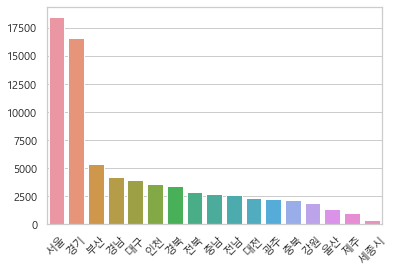

In [75]:
col1, col2 = st.columns(2)

d1 = my_df_region['시도코드명'].value_counts()
d1 = d1.reset_index()
d1.columns = ['시도코드명', '총 병원수']
    
with col1:
    st.write('총 의료시설 수')
    fig = plt.figure()
    sns.barplot(data=d1, x='시도코드명', y='총 병원수')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    
    st.pyplot(fig)

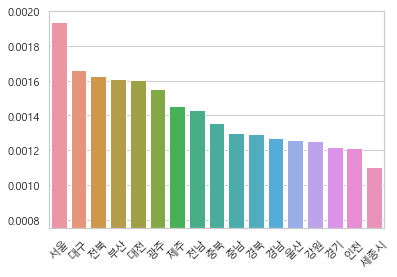

In [76]:
col1, col2 = st.columns(2)

hos_count = my_df_region.groupby('시도코드명')['종별코드명'].count().reset_index()
hos_count = hos_count.rename(columns={'종별코드명':'의료시설 수'})
pop_total2 = pop_total.reset_index()
pop_total2 = pop_total2.rename(columns = {'행정구역':'시도코드명'})
hos_ratio = pd.merge(hos_count, pop_total2)
hos_ratio['인구 대비 병원 비율'] = (hos_ratio['의료시설 수'] / hos_ratio['총 인구수'])
hos_ratio = hos_ratio.sort_values(by='인구 대비 병원 비율', ascending=False)
    
with col1:
    st.write('인구 수 대비 의료시설 비율')
    fig = plt.figure()
    sns.barplot(data=hos_ratio, x='시도코드명', y='인구 대비 병원 비율')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.ylim(0.00075, 0.002)
    
    st.pyplot(fig)

In [77]:
st.subheader('의사')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [78]:
doctor_region = my_doctor[my_doctor['지역'].isin(region)]

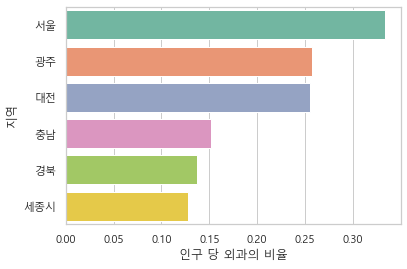

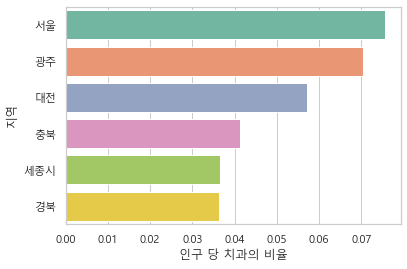

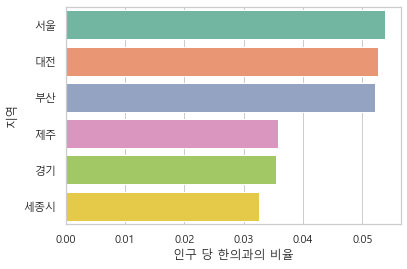

In [79]:
st.write('의사 수 많은 지역 상위, 하위 3개 비교')

def top3(col_name, top=3):
    doctor_region_top = doctor_region.sort_values(col_name, ascending=False).head(top)
    doctor_region_tail = doctor_region.sort_values(col_name, ascending=False).tail(top)
    doctor_region_doc = pd.concat([doctor_region_top,doctor_region_tail])
    fig = plt.figure()
    ax = sns.barplot(x=col_name, y='지역', data=doctor_region_doc)

    #ax.bar_label(ax.containers[0], label_type='center', color='white')
    return fig

col1, col2, col3 = st.columns(3)
with col1:
    st.write('외과의 비율')
    st.pyplot(top3('인구 당 외과의 비율'))
with col2:
    st.write('치과의 비율')
    st.pyplot(top3('인구 당 치과의 비율'))
with col3:
    st.write('한의과의 비율')
    st.pyplot(top3('인구 당 한의과의 비율'))

In [80]:
st.subheader('소아 병상')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [81]:
# 선택한 지역 데이터 필터링

age_region = my_age_total[my_age_total['시도코드명'].isin(region)]

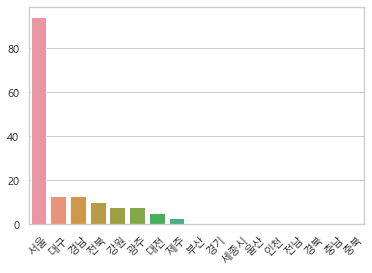

In [82]:
col1, co2 = st.columns(2)

with col1:
    st.write('소아중환자 병상 수')
    fig = plt.figure()
    a = age_region.sort_values(by='소아중환자병상수', ascending=False)
    sns.barplot(data=a, x='시도코드명', y='소아중환자병상수')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    
    st.pyplot(fig)

In [83]:
st.subheader('요양병원')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

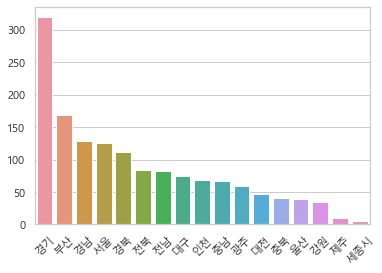

In [84]:
col1, co2 = st.columns(2)

with col1:
    st.write('요양병원 수')
    fig = plt.figure()
    a1 = age_region.sort_values(by='요양병원개수', ascending=False)
    sns.barplot(data=a1, x='시도코드명', y='요양병원개수')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    
    st.pyplot(fig)

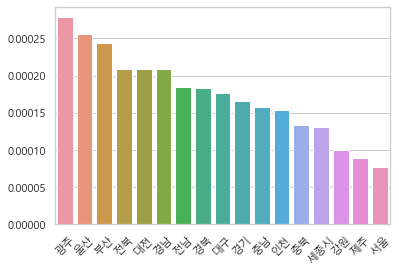

In [85]:
col1, co2 = st.columns(2)

with col1:
    st.write('노인 수 대비 요양병원 비율')
    fig = plt.figure()
    a2 = age_region.sort_values(by='노인요양병원비율', ascending=False)
    sns.barplot(data=a2, x='시도코드명', y='노인요양병원비율')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    
    st.pyplot(fig)

In [86]:
st.subheader('응급실')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [87]:
# 선택한 지역 데이터 필터링

my_em_region = my_em[my_em['시도'].isin(region)]

In [88]:
col1, col2 = st.columns(2)

# 주간/야간 선택
with col1:
    em_time = st.radio(label='운영 시간대 선택',
                      options=('주간 운영', '야간 운영', '주간/야간 운영'),
                      index=0)
    
c1 = (my_em_region['응급실 주간운영여부'] == 'Y')
c2 = (my_em_region['응급실 야간운영여부'] == 'Y')
em_count = my_em_region['응급실 주간운영여부'].count()

if em_time == '주간 운영':
    open_value = ((c1).sum() / em_count)
    open_value2 = round(open_value * 100, 3)
    
elif em_time == '야간 운영':
    open_value = ((c2).sum() / em_count)
    open_value2 = round(open_value * 100, 3)
    
else:
    open_value = ((c1&c2).sum() / em_count)
    open_value2 = round(open_value * 100, 3)

with col2:
    st.metric(label='응급실 수', value = int(open_value * em_count))
    st.metric(label = '응급실 운영 병원 비율(%)', value = open_value2)

In [89]:
st.write('응급실 수')

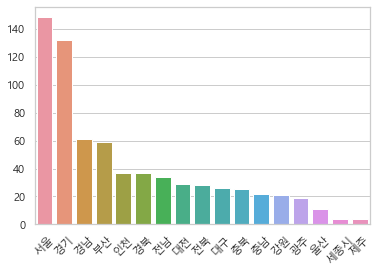

In [90]:
col1, col2 = st.columns(2)

if em_time == '주간 운영':
    my_em_region2 = my_em_region[c1]
elif em_time == '야간 운영':
    my_em_region2 = my_em_region[c2]
else:
    my_em_region2 = my_em_region[c1&c2]

        
with col1:
    fig = plt.figure()
    e1 = my_em_region2['시도'].value_counts().reset_index()
    e1.columns = ['시도', '응급실 수']
    sns.barplot(data = e1, x='시도', y='응급실 수')
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    
    st.pyplot(fig)

In [91]:
st.subheader('전문병원')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [92]:
sp_count = my_sp['시도코드명'].value_counts().reset_index()
sp_count.columns = ['시도', '전문병원 수']

sp_count = sp_count.append({'시도':'강원', '전문병원 수':0}, ignore_index=True)
sp_count = sp_count.append({'시도':'충남', '전문병원 수':0}, ignore_index=True)
sp_count = sp_count.append({'시도':'제주', '전문병원 수':0}, ignore_index=True)


# 선택한 지역 데이터 필터링
sp_region = sp_count[sp_count['시도'].isin(region)]

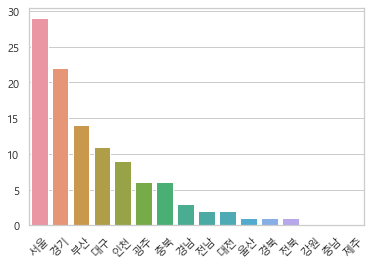

In [93]:
col1, col2 = st.columns(2)

with col1:
    st.write('전문병원 수')
    fig = plt.figure()

    sns.barplot(data=sp_region, x='시도', y='전문병원 수')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(rotation=45)
    
    st.pyplot(fig)